In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

## GPU

In [2]:
if torch.cuda.is_available() : 
    DEVICE = torch.device('cuda')
else : 
    DEVICE = torch.device('cpu')

print(torch.__version__, DEVICE)

1.7.1 cuda


## Constant

In [3]:
BATCH_SIZE = 32
EPOCHS = 10

## Data

In [4]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
# Cludeflare Protection을 해결해야함

train_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST",
                             train = False,
                             transform = transforms.ToTensor())

# 데이터를 Mini-Batch 단위로 분리 지정
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle = False)

## Data Check

In [5]:
for(X_train, y_train) in train_loader : 
    print('X_train : ', X_train.size(), 'type : ', X_train.type())
    print('y_train : ', y_train.size(), 'type : ', y_train.type())
    break

X_train :  torch.Size([32, 1, 28, 28]) type :  torch.FloatTensor
y_train :  torch.Size([32]) type :  torch.LongTensor


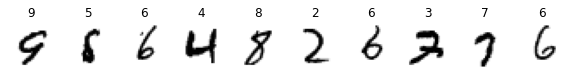

In [6]:
pltsize = 1
plt.figure (figsize = (10 * pltsize, pltsize))

for i in range(10) : 
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
    plt.title( str(y_train[i].item()))

## MLP Model

In [7]:
class Net(nn.Module) : 
    def __init__(self) : 
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        
    def forward(self, x) : 
        x = x.view(-1, 28 * 28) # Flatten 과정
        x = self.fc1(x)
        x = self.batch_norm1(x) # fc 전에도 가능
        x = F.relu(x) # activation function 85p
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1) # Log_softmax로 Grad를 좀 더 원활히 계산함 (Log 그래프 특성)
        return x

In [8]:
import torch.nn.init as init
def weight_init(m) : 
    if isinstance(m, nn.Linear) : 
        init.kaiming_uniform_(m.weight.data)

In [9]:
model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Train

In [10]:
def train(model, train_loader, optimizer, log_interval) : 
    model.train()
    
    for batch_idx, (image, label) in enumerate(train_loader) : 
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        """
        if batch_idx % log_interval == 0 :
            print("Train Epoch : {} [{}/{}({:.0f}%)]\tTrain Loss : {:.6f}".format(Epoch,
                                                                                  batch_idx * len(image),
                                                                                 len(train_loader.dataset),
                                                                                 100. * batch_idx / len(train_loader),
                                                                                 loss.item()))"""

In [11]:
def evaluate(model, test_loader) : 
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad() : 
        for image, label in test_loader : 
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
for Epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH : {}], \tTest Loss : {:.4f}, \tTest Accuracy : {:.2f} %\n".format(Epoch,
                                                                                     test_loss,
                                                                                     test_accuracy))


[EPOCH : 1], 	Test Loss : 0.0042, 	Test Accuracy : 96.14 %


[EPOCH : 2], 	Test Loss : 0.0032, 	Test Accuracy : 96.93 %


[EPOCH : 3], 	Test Loss : 0.0031, 	Test Accuracy : 97.00 %


[EPOCH : 4], 	Test Loss : 0.0029, 	Test Accuracy : 97.11 %


[EPOCH : 5], 	Test Loss : 0.0025, 	Test Accuracy : 97.50 %


[EPOCH : 6], 	Test Loss : 0.0022, 	Test Accuracy : 97.87 %


[EPOCH : 7], 	Test Loss : 0.0024, 	Test Accuracy : 97.66 %


[EPOCH : 8], 	Test Loss : 0.0022, 	Test Accuracy : 97.85 %


[EPOCH : 9], 	Test Loss : 0.0023, 	Test Accuracy : 97.92 %


[EPOCH : 10], 	Test Loss : 0.0020, 	Test Accuracy : 97.97 %



## Result

* ReLU - 97.41%, 0.0027
* BN - 98.05%, 0.0019
* HI - 97.19%, 0.0028
* Adam - 97.97%, 0.0020

Dropout - Generalization 효과, Ensemble과 비슷한 역할 80p <br>
ReLU - Vanishing Gradient Problem 완화 85p <br>
Batch Normalization - 히든 레이어의 비선형 함수 적용을 위해서 필요 89p <br>
He Initialization - 전역 최솟값 찾는데 유리함을 얻기 위해 적용 92p <br>
Adam - RMSProp에서 Momentum 방식의 특징을 결합한 방식 95p <br>
<hr>
RMSProp - 가보지 않은 곳은 많이 움직이고 가본 곳은 적게 움지깅는 Optimization 방식 <br>
RAdam - Adaptive Learning Rate Term의 분산을 교정하여 lr에 무관하게 비슷한 성능을 만듬 <br>